## Dropout

The first of these is the "dropout layer", which can help correct overfitting.

To recognize these spurious patterns a network will often rely on very a specific combinations of weight, a kind of "conspiracy" of weights. Being so specific, they tend to be fragile: remove one and the conspiracy falls apart.

This is the idea behind dropout. To break up these conspiracies, we randomly drop out some fraction of a layer's input units every step of training, making it much harder for the network to learn those spurious patterns in the training data. Instead, it has to search for broad, general patterns, whose weight patterns tend to be more robust.

![image.png](assets/a86utxY.gif 'image')

## Adding Dropout

In Keras, the dropout rate argument rate defines what percentage of the input units to shut off. Put the Dropout layer just before the layer you want the dropout applied to:

```python
keras.Sequential([
    # ...
    layers.Dropout(rate=0.3), # apply 30% dropout to the next layer
    layers.Dense(16),
    # ...
])

## Batch Normalization

The next special layer we'll look at performs "batch normalization" (or "batchnorm"), which can help correct training that is slow or unstable.

With neural networks, it's generally a good idea to put all of your data on a common scale, perhaps with something like scikit-learn's StandardScaler or MinMaxScaler. The reason is that SGD will shift the network weights in proportion to how large an activation the data produces. Features that tend to produce activations of very different sizes can make for unstable training behavior.

Now, if it's good to normalize the data before it goes into the network, maybe also normalizing inside the network would be better! In fact, we have a special kind of layer that can do this, the batch normalization layer. A batch normalization layer looks at each batch as it comes in, first normalizing the batch with its own mean and standard deviation, and then also putting the data on a new scale with two trainable rescaling parameters. Batchnorm, in effect, performs a kind of coordinated rescaling of its inputs.

Most often, batchnorm is added as an aid to the optimization process (though it can sometimes also help prediction performance). Models with batchnorm tend to need fewer epochs to complete training. Moreover, batchnorm can also fix various problems that can cause the training to get "stuck". Consider adding batch normalization to your models, especially if you're having trouble during training.

## Adding Batch Normalization

```python
layers.Dense(16, activation='relu'),
layers.BatchNormalization()
```
...or between a layer and its activation function:

```python
layers.Dense(16),
layers.BatchNormalization(),
layers.Activation('relu'),
```

In [3]:
# Setup plotting
import matplotlib.pyplot as plt

# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)


import pandas as pd
red_wine = pd.read_csv('input/red-wine.csv')

# Create training and validation splits
df_train = red_wine.sample(frac=0.7, random_state=0)
df_valid = red_wine.drop(df_train.index)

# Split features and target
X_train = df_train.drop('quality', axis=1)
X_valid = df_valid.drop('quality', axis=1)
y_train = df_train['quality']
y_valid = df_valid['quality']

In [4]:
from tensorflow import keras
from tensorflow.keras import layers, callbacks

model = keras.Sequential([
    layers.Dense(1024, activation='relu', input_shape=[11]),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(1),
])

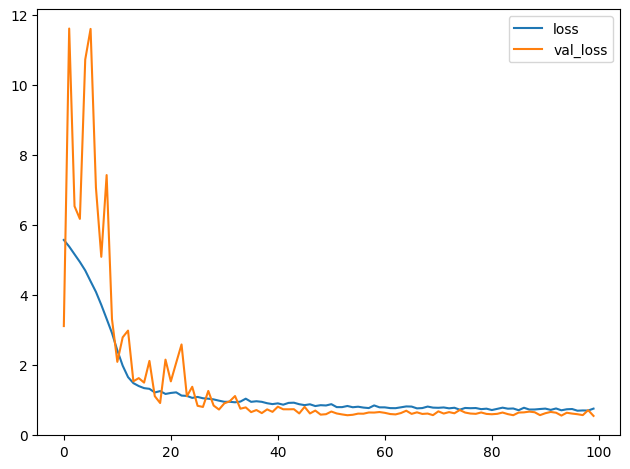

In [5]:
model.compile(
    optimizer='adam',
    loss='mae',
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=256,
    epochs=100,
    verbose=0,
)


# Show the learning curves
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot();

In [8]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.model_selection import GroupShuffleSplit


spotify = pd.read_csv('input/spotify.csv')

X = spotify.copy().dropna()
y = X.pop('track_popularity')
artists = X['track_artist']

features_num = ['danceability', 'energy', 'key', 'loudness', 'mode',
                'speechiness', 'acousticness', 'instrumentalness',
                'liveness', 'valence', 'tempo', 'duration_ms']
features_cat = ['playlist_genre']

preprocessor = make_column_transformer(
    (StandardScaler(), features_num),
    (OneHotEncoder(), features_cat),
)

def group_split(X, y, group, train_size=0.75):
    splitter = GroupShuffleSplit(train_size=train_size)
    train, test = next(splitter.split(X, y, groups=group))
    return (X.iloc[train], X.iloc[test], y.iloc[train], y.iloc[test])

X_train, X_valid, y_train, y_valid = group_split(X, y, artists)

X_train = preprocessor.fit_transform(X_train)
X_valid = preprocessor.transform(X_valid)
y_train = y_train / 100
y_valid = y_valid / 100

input_shape = [X_train.shape[1]]
print("Input shape: {}".format(input_shape))

Input shape: [18]


In [10]:
model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=input_shape),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1)
])

Minimum Validation Loss: 0.1899


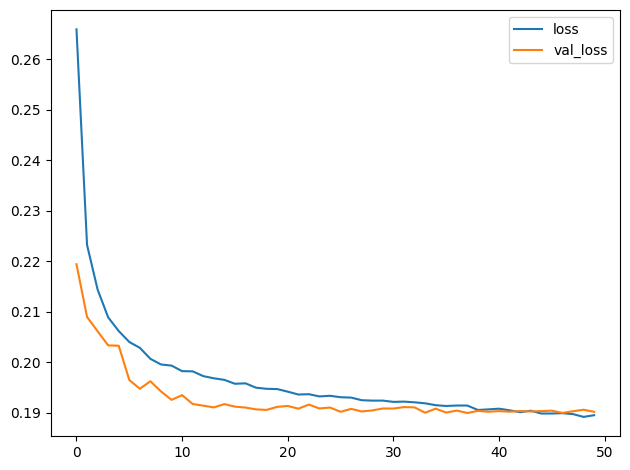

In [11]:
model.compile(
    optimizer='adam',
    loss='mae',
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=50,
    verbose=0,
)
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()))